# Dask Data structures

Dask offers several pythonic data structures to handle and operate with larger-than-memory data in a distributed system.
- `dask.bag`: distributed generic python list. The Dask equivalent to a PySpark RDD
- `dask.array`: distributed numpy arrays
- `dask.dataframe`: distributed pandas dataframes

All the high-level data structure APIs are optimized to exploit the DAG optimization features of the Dask scheduler, and thus rely on lazy computation.

## Start the Dask cluster

In [2]:
# set this variable with one of the following values

# -> 'local'
# -> 'docker_container'
# -> 'docker_cluster'

CLUSTER_TYPE ='docker_cluster'

In [3]:
%env CLUSTER_TYPE $CLUSTER_TYPE

env: CLUSTER_TYPE=docker_cluster


In [4]:
%%script bash --bg --out script_out

if [[ "$CLUSTER_TYPE" != "docker_cluster" ]]; then
    echo "Launching scheduler and worker"
    
    HOSTIP=`hostname -I | xargs`
    
    echo "dask-scheduler --host $HOSTIP --dashboard-address $HOSTIP:8787"
    
    # dask scheduler 
    dask-scheduler --host $HOSTIP --dashboard-address $HOSTIP:8787 &

    # dask worker
    dask-worker $HOSTIP:8786 --memory-limit 2GB --nworkers 2 &

fi

In [5]:
host_ip = !hostname -I | xargs
host_ip = host_ip[0]

In [6]:
from dask.distributed import Client

if CLUSTER_TYPE == 'local':
    
    client = Client()

elif CLUSTER_TYPE == 'docker_container':
    
    client = Client('{}:8786'.format(host_ip))
    
elif CLUSTER_TYPE == 'docker_cluster':
    
    # use the provided master
    client = Client('dask-scheduler:8786')
    
client

<Client: 'tcp://172.18.0.2:8786' processes=2 threads=2, memory=0.95 GiB>

## Dask Bag

Bags are very powerful and flexible data structures.
The Dask Bag offers essentially the same degree of flexibility as the RDD in pySpark.
They are parallelized general collections of objects, like Python’s built-in `list`, and can therefore hold any Python objects, whether they are custom classes or built-in types. 
This makes it possible to contain very complicated data structures, like raw text or nested JSON data, and navigate them with ease.

For these reasons, Dask bags are often used to parallelize simple computations on unstructured or semi-structured data like text data, log files, JSON records, or user defined Python objects, using MapReduce-like approaches to load/inspect/filter arbitrary datasets (structured or unstructured).

Dask Bag implements in fact operations like `map`, `filter`, `groupby` and aggregations on collections of Python objects.
It does this in parallel using Python iterators similarly to a parallel version of itertools.

Once a first stage of data-preparation is completed using Dask Bag, it is quite common to reduce and convert the data into more suitable data structures, such as Dask Arrays or Dask Dataframes, which will be covered later on.

### Create and Take from a Bag

We can create a `Bag` from a Python sequence, from files, from data on cloud-storage such as Amazon AWS S3, etc.
For a comprehensive overview on the ways to access remote data from DFS, S3, and others, do refer to the official documentation at the [link](https://docs.dask.org/en/stable/how-to/connect-to-remote-data.html).

We can as well create a Bag from a function we have declared as `delayed`.
This way, we can generate data from a distributed application, and then access the data with the bag API before computing a result.

The data are partitioned into blocks, usually with multiple items per block, depending on the datasets, the cluster resources, and our choice with the parameter `npartitions`.

Let's start by creating some simple data from a python list.
Clearly, as python is a dinamically typed language, this can be a simple array of integers, or an arbitrary collection fo multiple data types (numbers, strings, objects, ...).

In [1]:
import dask.bag as db

# each element is an integer
data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

b = db.from_sequence(data, npartitions=4)

As previosly mentioned, Dask data structures embody the lazy programming paradigm.
The data is thus not yet stored on the cluster, as we have not acted with an operation such as `compute`.

In general, we don't want to return the entire data stored on the cluster, but we might want to inspect few elements.
We can do that with `take(n_elements)`.
The returned data will be a tuple containing the first n_elements of the Bag.

In [8]:
b.take(3)

(1, 2, 3)

Data can be extracted from text files by providing the list of all files, or with the `*` wildcard.

By default, the resulting bag will have one item per line and one file per partition (so be careful when partitioning the data).

A nice feature of reading text files Dask is that it handles standard compression libraries (like gzip, bz2, xz) automatically as they will be inferred by the file name extension, or by using the compression='gzip' keyword.

For instance, we can load up in a Bag a number of files from a local folder:

In [9]:
! ls datasets/accounts_json/. 

accounts.00.json.gz  accounts.17.json.gz  accounts.34.json.gz
accounts.01.json.gz  accounts.18.json.gz  accounts.35.json.gz
accounts.02.json.gz  accounts.19.json.gz  accounts.36.json.gz
accounts.03.json.gz  accounts.20.json.gz  accounts.37.json.gz
accounts.04.json.gz  accounts.21.json.gz  accounts.38.json.gz
accounts.05.json.gz  accounts.22.json.gz  accounts.39.json.gz
accounts.06.json.gz  accounts.23.json.gz  accounts.40.json.gz
accounts.07.json.gz  accounts.24.json.gz  accounts.41.json.gz
accounts.08.json.gz  accounts.25.json.gz  accounts.42.json.gz
accounts.09.json.gz  accounts.26.json.gz  accounts.43.json.gz
accounts.10.json.gz  accounts.27.json.gz  accounts.44.json.gz
accounts.11.json.gz  accounts.28.json.gz  accounts.45.json.gz
accounts.12.json.gz  accounts.29.json.gz  accounts.46.json.gz
accounts.13.json.gz  accounts.30.json.gz  accounts.47.json.gz
accounts.14.json.gz  accounts.31.json.gz  accounts.48.json.gz
accounts.15.json.gz  accounts.32.json.gz  accounts.49.json.gz
accounts

In [10]:
import os
b = db.read_text(os.path.join('datasets','accounts_json','accounts.*.json.gz'),
                 files_per_partition=4)
example = b.take(1)

print(type(example))
print(example)

<class 'tuple'>
('{"id": 0, "name": "Dan", "transactions": [{"transaction-id": 14, "amount": 4526}, {"transaction-id": 2814, "amount": 4412}, {"transaction-id": 4918, "amount": 4301}, {"transaction-id": 12573, "amount": 4215}, {"transaction-id": 14264, "amount": 4428}, {"transaction-id": 15537, "amount": 4317}, {"transaction-id": 18212, "amount": 4644}, {"transaction-id": 21465, "amount": 4351}, {"transaction-id": 24422, "amount": 4292}, {"transaction-id": 29525, "amount": 4297}, {"transaction-id": 36043, "amount": 4232}, {"transaction-id": 41620, "amount": 4405}, {"transaction-id": 42443, "amount": 4356}, {"transaction-id": 43028, "amount": 4243}, {"transaction-id": 46824, "amount": 4320}, {"transaction-id": 48087, "amount": 4501}, {"transaction-id": 51930, "amount": 4345}, {"transaction-id": 52633, "amount": 4214}, {"transaction-id": 57717, "amount": 4388}, {"transaction-id": 60042, "amount": 4419}, {"transaction-id": 63538, "amount": 4434}, {"transaction-id": 70414, "amount": 4357},

`Bag` objects hold the standard functional APIs including `map`, `filter`, `groupby`, etc..

Operations on `Bag` objects create new bags, thus we can daisy-chain multiple operations together to manipulate the data until we reach the desired result.  

We can finally call the `.compute()` method to trigger execution, as we saw for any `delayed` object.  

As a bag is always a delayed object in nature, there is no real need to specify that the functions we want to apply to the dataset are further delayed. 


In [11]:
def is_even(n):
    return n % 2 == 0

b = db.from_sequence([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
c = b.filter(is_even).map(lambda x: x ** 2)
c

dask.bag<lambda, npartitions=10>

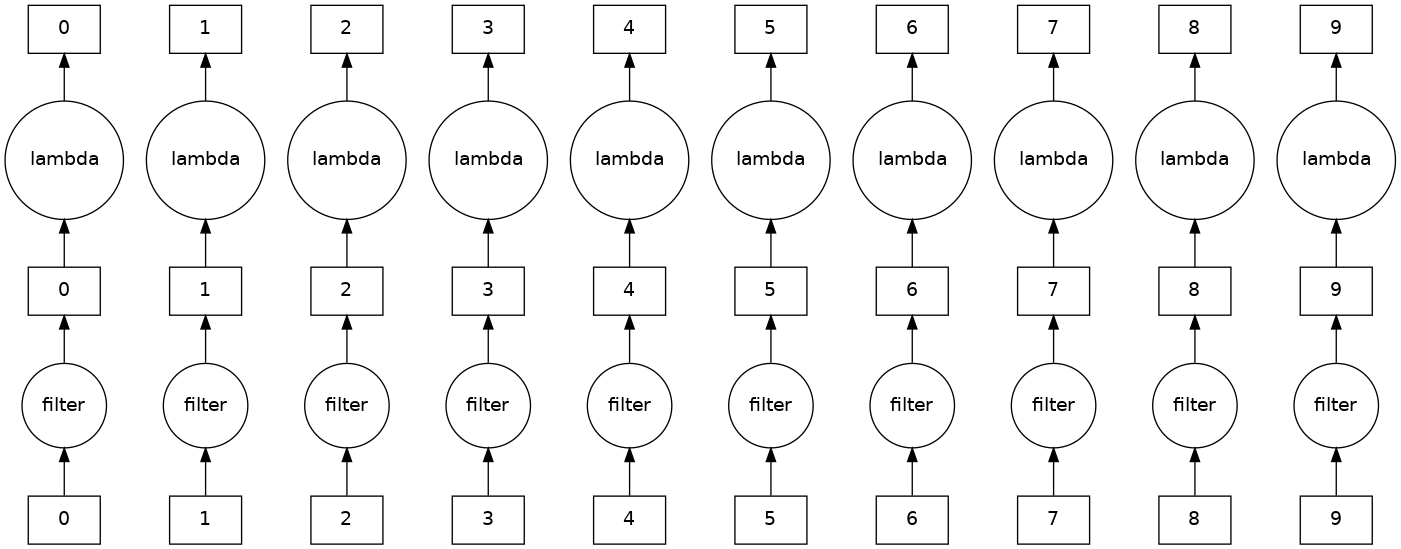

In [12]:
c.visualize()

Automatically created a partition for each element. 

In [13]:
c.compute()

[4, 16, 36, 64, 100]

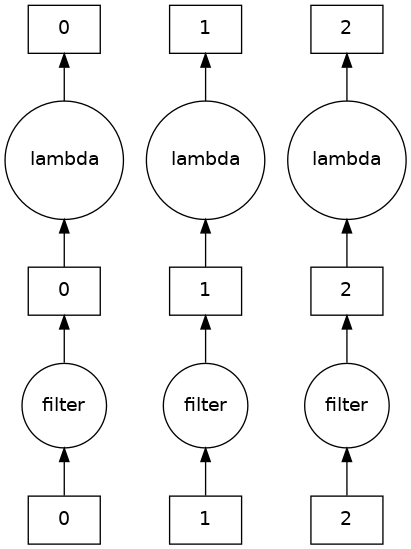

In [14]:
b = db.from_sequence([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], npartitions=3)
c = b.filter(is_even).map(lambda x: x ** 2)
c.visualize()

In [15]:
c.compute()

[4, 16, 36, 64, 100]

### Example: Open and preprocess JSON data

We'll start from the dummy dataset of gzipped JSON data in your data directory.
This is a dataset analogous to what you might collect off of a document store database (e.g. Mongo) or by scaping a website using the dedicated API.

Each line of each documnent is a JSON encoded dictionary with the following keys

*  `id`: Unique identifier of the customer
*  `name`: Name of the customer
*  `transactions`: a list of key-value pairs in the form of `transaction-id` and `amount` pairs (one for each transaction for the customer in that file)

1. Create a Bag reading out the dataset from the text files 
2. Map the `json.loads` function on each message to extract the data in the form of python dictionaries

In [23]:
# 1. create a dask bag from the files
db_lines = db.read_text(os.path.join('datasets','accounts_json','accounts.*.json.gz'),
                 files_per_partition=4)
example = db_lines.take(1)

print(type(example))
print(example)


<class 'tuple'>
('{"id": 0, "name": "Dan", "transactions": [{"transaction-id": 14, "amount": 4526}, {"transaction-id": 2814, "amount": 4412}, {"transaction-id": 4918, "amount": 4301}, {"transaction-id": 12573, "amount": 4215}, {"transaction-id": 14264, "amount": 4428}, {"transaction-id": 15537, "amount": 4317}, {"transaction-id": 18212, "amount": 4644}, {"transaction-id": 21465, "amount": 4351}, {"transaction-id": 24422, "amount": 4292}, {"transaction-id": 29525, "amount": 4297}, {"transaction-id": 36043, "amount": 4232}, {"transaction-id": 41620, "amount": 4405}, {"transaction-id": 42443, "amount": 4356}, {"transaction-id": 43028, "amount": 4243}, {"transaction-id": 46824, "amount": 4320}, {"transaction-id": 48087, "amount": 4501}, {"transaction-id": 51930, "amount": 4345}, {"transaction-id": 52633, "amount": 4214}, {"transaction-id": 57717, "amount": 4388}, {"transaction-id": 60042, "amount": 4419}, {"transaction-id": 63538, "amount": 4434}, {"transaction-id": 70414, "amount": 4357},

In [24]:
# 2. read the data from the json format
from json import loads

db_js = db_lines.map(loads)

example = db_js.take(2)

print(type(example))
print(example)


<class 'tuple'>
({'id': 0, 'name': 'Dan', 'transactions': [{'transaction-id': 14, 'amount': 4526}, {'transaction-id': 2814, 'amount': 4412}, {'transaction-id': 4918, 'amount': 4301}, {'transaction-id': 12573, 'amount': 4215}, {'transaction-id': 14264, 'amount': 4428}, {'transaction-id': 15537, 'amount': 4317}, {'transaction-id': 18212, 'amount': 4644}, {'transaction-id': 21465, 'amount': 4351}, {'transaction-id': 24422, 'amount': 4292}, {'transaction-id': 29525, 'amount': 4297}, {'transaction-id': 36043, 'amount': 4232}, {'transaction-id': 41620, 'amount': 4405}, {'transaction-id': 42443, 'amount': 4356}, {'transaction-id': 43028, 'amount': 4243}, {'transaction-id': 46824, 'amount': 4320}, {'transaction-id': 48087, 'amount': 4501}, {'transaction-id': 51930, 'amount': 4345}, {'transaction-id': 52633, 'amount': 4214}, {'transaction-id': 57717, 'amount': 4388}, {'transaction-id': 60042, 'amount': 4419}, {'transaction-id': 63538, 'amount': 4434}, {'transaction-id': 70414, 'amount': 4357}, 

Once the JSON data is mapped into the proper Python objects (dictionaries, lists, etc.) we can perform dedicated opeartions by creating small Python functions to run on our data.

The most basic operations we can perform on a Dask Bag are the following:
- `map`: apply a function to each element
- `filter`: retain only the elements passing a given function
- `pluck`: select a specific nested field, as from a python dictionary `element[field]`
- `flatten`: un-fold the dictionary into a list-like object

1. compute the average number of transactions for each entry of a user named "Alice"

In [25]:
# retain only the records from users named "Alice"

db_js.filter(lambda record: record['name']='Alice').take(5)

SyntaxError: expression cannot contain assignment, perhaps you meant "=="? (2248319342.py, line 3)

In [ ]:
# retain only the records from users named "Alice"
# AND count the total number of transactions for each entry in the dataset 


: 

: 

: 

In [ ]:
# retain only the records from users named "Alice"
# AND count the total number of transactions (as 'count') for each entry in the dataset 
# AND return only the 'count' values


: 

: 

: 

In [ ]:
# retain only the records from users named "Alice"
# AND count the total number of transactions (as 'count') for each entry in the dataset 
# AND return only the 'count' values
# AND compute the average of the counts


: 

: 

: 

In [ ]:
# visualize the graph of the tasks composing the job


: 

: 

: 

2. compute the average amount for all transactions for all users named "Alice"

In [ ]:
# retain only the relevant transactions


: 

: 

: 

In [ ]:
# retain only the relevant transactions
# AND return only the "amount" in a bag


: 

: 

: 

In [ ]:
# retain only the relevant transactions
# AND return only the "amount" in a bag
# AND compute the average of all transactions amounts


: 

: 

: 

In [ ]:
# visualize the graph of the tasks composing the job

: 

: 

: 

Additional standard operations on Dask Bags can be performed by mean of groupby and aggregation functions.

-  `groupby`:  Shuffles data so that all items with the same key are in the same key-value pair
-  `foldby`:  Walks through the data accumulating a result per key. It works as a combined groupby and reduce operation, and it allows for efficient parallel split-apply-combine tasks.

As always, we must remember that any "data-shuffle heavy" operation (such as `groupby`) are very expensive as they require to move the data across the workers.
The `foldby` method in Dask is more complex to use but also much "cheaper" in terms of the computational time required, so it should be preferred whenever possibile to use it.

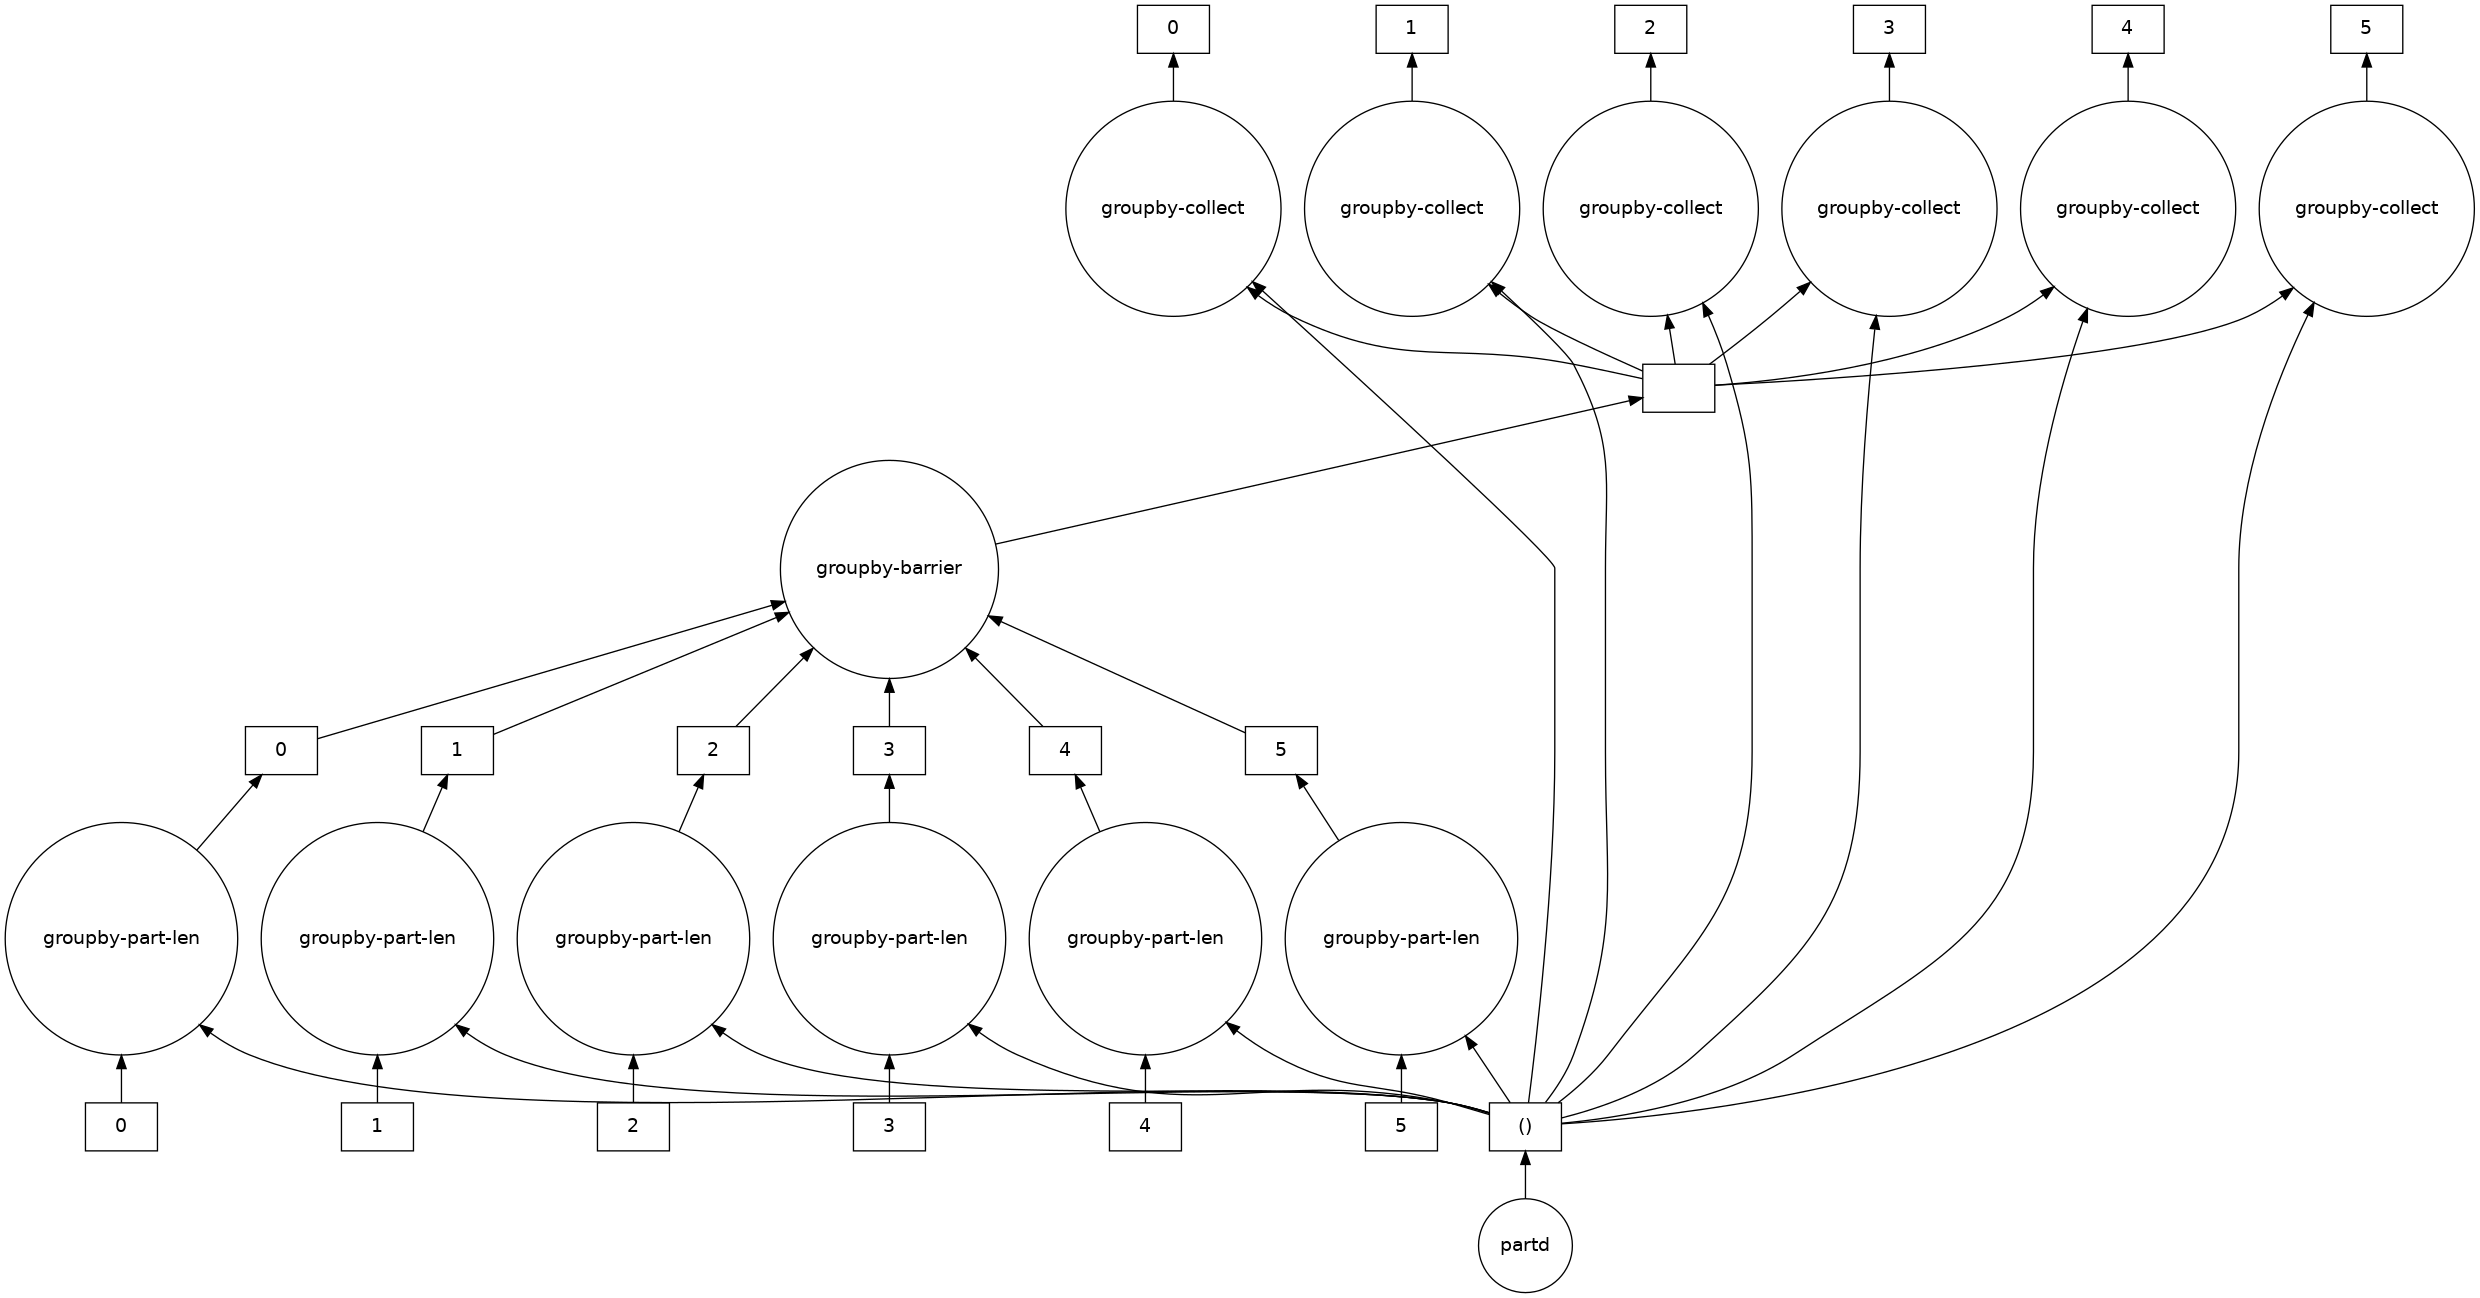

In [2]:
names_data = ['Alice', 'Bob', 'Charlie', 'Dan', 'Edith', 'Frank']

# create a bag from the list of names
b = db.from_sequence(names_data)

# group names by length
res = b.groupby(len) 

# visualize this "simple" graph
res.visualize()

In [3]:
res.compute()

[(7, ['Charlie']), (3, ['Bob', 'Dan']), (5, ['Alice', 'Edith', 'Frank'])]

Notice how the result of the groupby operation is a tuple.
If we need to apply functions on the elements of the tuples we can use `starmap`.

The `starmap` function in Dask allows to apply a function using argument tuples, similarly to what the standard `itertools.starmap` does in python.

For instance:

In [ ]:
# create a simple bag from a list of integers
b = db.from_sequence(list(range(10)))

# groupby even/odd numbers
b.groupby(lambda x: x % 2).compute()

[(0, [0, 2, 4, 6, 8]), (1, [1, 3, 5, 7, 9])]

: 

We obtain 2 groups that are tuples. 

In [4]:
# return the max of all elements in each group
b.groupby(lambda x: x % 2)\
 .starmap(lambda k, v: (k, max(v)))\    
 .compute()

# starmap: useful function to work on tuples

SyntaxError: unexpected character after line continuation character (2805298972.py, line 3)

In [40]:
# return the sum of the elements in each group
res =  b.groupby(lambda x: x % 2)\
 .starmap(lambda k, v: (k, sum(v)))\    
 .compute()

res.visualize()

SyntaxError: unexpected character after line continuation character (480246810.py, line 3)

In [ ]:
# Take a look at the graph once again


: 

: 

: 

Foldby can be quite odd at first.  It is similar to the following functions from other libraries:

*  [`toolz.reduceby`](http://toolz.readthedocs.io/en/latest/streaming-analytics.html#streaming-split-apply-combine)
*  [`pyspark.RDD.combineByKey`](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.RDD.combineByKey.html)

When using `foldby` you must provide:

1.  A key function on which to group elements (so far, a groupby equivalent)
2.  A binary operator such as you would pass to `reduce` that you use to perform reduction per each group
3.  A combine binary operator that can combine the results of two `reduce` calls on different parts of your dataset.

In the Dask documentation this is summarized by stating that a `foldby` call such as this:
```python
dask_bag.foldby(key, binop, init)
```

Will be equivalent to a combination of two operations: a groupby and a reduce:

```python
def reduction(group):                               
    return reduce(binop, group, init)               

dask_bag.groupby(key).map(lambda (k, v): (k, reduction(v)))
```

The reduction operation must be associative. It will happen in parallel in each of the partitions of the dataset. Then all of these intermediate results will be combined by the `combine` binary operator.

Let's re-write the equivalent group-by + starmap operation with a foldby call

```python
b.groupby(lambda x: x % 2).starmap(lambda k, v: (k, sum(v))).compute()
```

In [ ]:
# create a simple bag from a list of integers
b = db.from_sequence(list(range(10)))

: 

: 

: 

In [ ]:
# groupby even/odd numbers with a foldby and find the total sum per group
#
#   write down a binary filter function to select only even or odd numbers
#   write down a reduce-like operation to sum all elements
is_even = lambda x: x % 2 == 0
add = lambda x, y: x + y
b.foldby(is_even, add, initial=0).compute()

: 

: 

: 

In [ ]:
# have a look at the graph and compare it with the groupby implementation
# `split_every` defaults to 8
b.foldby(is_even, add, split_every=8).visualize()

: 

: 

: 

### Example with account data

Take a moment to look to the `foldby` API at the [link](https://docs.dask.org/en/latest/generated/dask.bag.Bag.foldby.html#dask.bag.Bag.foldby).

- Get the total number of users with the same name from the account dataset
  1. Use a `groupby` function and measure the required computational time
  2. Use a `foldby` function and measure the required computational time

In [ ]:
# group-by implementation
%%time
result_groupby = """your code here"""

: 

: 

: 

In [ ]:
# fold-by implementation
%%time
from operator import add

def incr(tot, _):
    """your code here"""

result_foldby = """your code here"""

: 

: 

: 

Compute total transfers amount per each name using a `foldby`

We can proceed in two steps:
1.  Create a function that given the input dictionary

        {'name': 'Alice', 'transactions': [{'amount': 1, 'id': 123}, {'amount': 2, 'id': 456}]}
        
    produces the sum of the amounts, e.g. `3` in this case
    
2.  Modify the binary operator of the `foldby` example above so that the binary operator doesn't count the number of entries, but instead accumulates the sum of the transferred amounts

In [ ]:
# fold-by implementation (do not compute the result just yet)
result_foldby = """your code here"""

: 

: 

: 

In [ ]:
# visualize the foldby operation
result_foldby.visualize()

: 

: 

: 

In [ ]:
# compute and time the execution
%%time
result_foldby = result_foldby.compute()

: 

: 

: 

In [ ]:
# inspect the result
print(sorted(result_foldby))

: 

: 

: 

## From Bag to pre-processed output datasets

Dask Bags are often used as an "entry-point" to ingest, decode and pre-process data, before either storing the results as an intermediated dataset (thus ready for further processing), or to flatten and structure the dataset to start using the Dask Dataframe API.

Dask offers a number of methods to convert Bags into output data objects such as text files, JSON files, and more.
Have a look at the documentation at the [link](https://docs.dask.org/en/stable/bag-creation.html#store-dask-bags) to see how these methods store the Dask Bag:
- `to_textfiles`
- `to_avro`
- `to_delayed`

By far the most widely used approach in data pre-processing using Dask Bags is to `extract` some raw data from the original input source, `transform` it applying some funcions to filter/reduce/create features from the original (usually messy) dataset, and finally `load` the clensed dataset into either a DataBase or a further data processing pipeline based on *structured* data.

Converting a Dask Bag to a Dask Dataframe is thus a very common operation (very similar to the conversion from RDD to a Spark DataFrame).

In order to convert arbitrary data into a stuctured table view, we need to flatten and normalize the dataset before invoking the `to_dataframe` Dask Bag function.

As a purely illustrative example, our account data is deeply nested and not suitable for being transformed into a table-like dataframe structure.

Assuming we may want to retain only the first transaction per customer, we can flatten the dataset by mapping a dedicated function:

In [ ]:
print( db_js.take(1) )

: 

: 

: 

In [ ]:
def dummy_flatten(record):
    return {
        'id': record['id'],
        'name': record['name'],
        'first_transaction_id': record['transactions'][0]['transaction-id'],
        'first_transaction_amount': record['transactions'][0]['amount']
    }

db_js.map(dummy_flatten).take(1)    

: 

: 

: 

In [ ]:
dd = db_js.map(dummy_flatten).to_dataframe() # dask dataframe

: 

: 

: 

In [ ]:
dd

: 

: 

: 

In [ ]:
dd.head(10)

: 

: 

: 